# Camera Calibration Notebook

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb

In [3]:
dirs = ["./data/synth_1"] #Insert video directory here

## Pixel Reprojection error ( Total and Across Bins)

In [4]:
frame_dir = os.path.join(dirs[0], 'frames')
if not (os.path.exists(frame_dir)):
    os.makedirs(frame_dir)

In [5]:
frame_dir

'./data/synth_1/frames'

(0.1, 0)
(0.2, 0)
(0.30000000000000004, 41)
total error: 0.0134963769079 for scaling of 0.3 with 41 number of images for file ./data/synth_1/video.avi


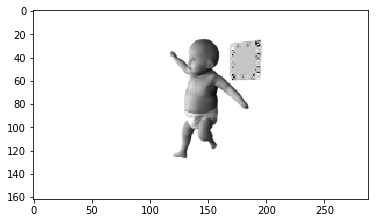

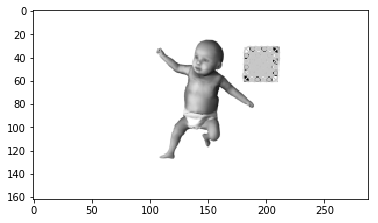

In [9]:
global_dict_no_eq = {}
for d in dirs:
#     flist = sorted(glob.glob(os.path.join(d, "*.mp4")))
    flist = [os.path.join(d, "video.avi")]
    
    for vf in flist:
#         print(vf)
#         vidcap = cv2.VideoCapture(vf)

#         files = glob.glob("{}/*".format(frame_dir))
#         for fl in files:
#             os.remove(fl)

#         success,image = vidcap.read()
#         count = 0
#         success = True
#         while success:
#             success,image = vidcap.read()
#             cv2.imwrite("%s/frame%d.png" % (frame_dir,count), image)     # save frame as PNG file
#             if cv2.waitKey(10) == 27:                     # exit if Escape is hit
#                 break
#             count += 1

#         print(count)

        count = len(os.listdir(frame_dir))
        nx = 5
        ny = 5
        bins = 6
        
        
        interval = count/bins

        mesh = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        objp = np.hstack((mesh, np.zeros(shape = (nx*ny,1))))
        objp = np.array(objp, dtype = np.float32)

        fname = glob.glob('{}/*.png'.format(frame_dir))
        
        for j in range(1,4):

            imgpoints = []
            objpoints = []
            imgpoints2_list = []
            detected_list = []
            bin_error = []
            bincount = np.zeros(6)
            fx = j*0.1
            fy = j*0.1
            for i,f in enumerate(fname):
                try:
                    imcv = cv2.imread(f)
                    imcv = cv2.cvtColor(imcv, cv2.COLOR_BGR2GRAY)

####### Uncomment below two lines to apply histogram equalization for removing shiny effects, cl = 2, 5 or 10 work best #####                    

                    cli = cv2.createCLAHE(clipLimit = 10)
                    imcv = cli.apply(imcv)

#                     imcv = cv2.GaussianBlur(imcv, ksize = (5,5), sigmaX = 1, sigmaY = 1)
                    imcv = cv2.resize(imcv, (0, 0), fx=fx, fy=fy, interpolation=cv2.INTER_AREA)


                    retval, corners = cv2.findChessboardCorners(imcv,(nx,ny), None)
                    if (retval == True):

                        detected_list.append(f)
###### Uncomment below lines to plot the detected checkerboard corners #######
                        if i % 60 == 0:
                            plt.figure()
                            cv2.drawChessboardCorners(imcv, (nx, ny), corners, retval)
                            plt.imshow(imcv, cmap='gray')

                        imgpoints.append(corners)
                        objpoints.append(objp*20)
                        bincount[int(i/interval)] += 1
                              
                except Exception as e:
                    pass

            print(fx, len(objpoints))
            mean_error = 1.0
            mtx = dist = rvecs = tvecs = []
            if (len(objpoints) != 0):
                retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imcv.shape[::-1], None, None)
                mean_error = 0.0
                
                tot_len = len(objpoints)
                st = 0
                for b in range(bins):
                    berror = 0.0
                    if b != 0 :
                        st += bincount[b-1]
                    else: 
                        st = 0
                    end = st + bincount[b]
                    for i in range(int(st),int(end)):
                        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
                        imgpoints2_list.append(imgpoints2)
                        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
                        berror += error
                    if bincount[b] != 0:
                        bin_error.append(berror/bincount[b])
                    else:
                        berror = 1.0

                for i in range(len(objpoints)):
                    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
                    imgpoints2_list.append(imgpoints2)
                    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
                    mean_error += error
                print( "total error: {} for scaling of {} with {} number of images for file {}".format(mean_error/len(objpoints), fx, len(objpoints), vf))

            if vf not in global_dict_no_eq:
                global_dict_no_eq[vf] = []

            global_dict_no_eq[vf].append([fx, len(objpoints), mean_error/(len(objpoints)+0.00001), mtx, dist,detected_list,imgpoints, bin_error, bincount])

## Plot of reprojection errors across bins

In [6]:
import pickle
pickle_out = open("field.pkl","wb")
pickle.dump(global_dict_no_eq, pickle_out)
pickle_out.close()

In [6]:
plot_dict1 = {}
plot_dict2 = {}
plot_dict3 = {}


bin_dict1 = {}
bin_dict2 = {}
bin_dict3 = {}


In [7]:
for key in global_dict_no_eq:
    l = global_dict_no_eq[key]
    plot_dict1[key] = l[0][7]
    bin_dict1[key] = l[0][8]
    plot_dict2[key] = l[1][7]
    bin_dict2[key] = l[1][8]
    plot_dict3[key] = l[2][7]
    bin_dict3[key] = l[2][8]

In [8]:
for key in plot_dict1.keys():
    print(key, plot_dict1[key])

In [9]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)

In [10]:
layout1 = go.Layout(
    title='Reprojection Error Plot(fx = 0.1)',
    yaxis = dict(title='error'),
    xaxis = dict(title='bins')
)

trace1 = []
trace2 = []
trace3 = []



for key in plot_dict1.keys():
    trace_temp = go.Scatter(
    x = np.arange(6),
    y = plot_dict1[key],
    mode='lines+markers'
    )


for key in plot_dict2.keys():
    trace_temp = go.Scatter(
    x = np.arange(6),
    y = plot_dict2[key],
    mode='lines+markers'
    )

    
for key in plot_dict3.keys():
    trace_temp = go.Scatter(
    x = np.arange(6),
    y = plot_dict3[key],
    mode='lines+markers'
    )


layout2 = go.Layout(
    title='Reprojection Error Plot(fx = 0.2)',
    yaxis = dict(title='error'),
    xaxis = dict(title='bins')
)

layout3 = go.Layout(
    title='Reprojection Error Plot(fx = 0.3)',
    yaxis = dict(title='error'),
    xaxis = dict(title='bins')
)

In [11]:
fig1 = go.Figure(data=trace1, layout=layout1)
fig2 = go.Figure(data=trace2, layout=layout2)
fig3 = go.Figure(data=trace3, layout=layout3)

In [12]:
# fig1 = go.Figure(data=[trace11,trace12,trace13,trace14], layout=layout1)
# fig2 = go.Figure(data=[trace21,trace22,trace23,trace24], layout=layout2)
# fig3 = go.Figure(data=[trace31,trace32,trace33,trace34], layout=layout3)

In [13]:
py.offline.iplot(fig1)
py.offline.iplot(fig2)
py.offline.iplot(fig3)

In [14]:
layout1 = go.Layout(
    title='Images detected Plot(fx = 0.1)',
    yaxis = dict(title='num_image'),
    xaxis = dict(title='bins')
)

trace1 = []
trace2 = []
trace3 = []

for key in bin_dict1.keys():
    trace_temp = go.Scatter(
    x = np.arange(6),
    y = bin_dict1[key],
    mode='lines+markers'
    )
    trace1.append(trace_temp)
    
for key in bin_dict2.keys():
    trace_temp = go.Scatter(
    x = np.arange(6),
    y = bin_dict2[key],
    mode='lines+markers'
    )
    trace2.append(trace_temp)
    
for key in bin_dict3.keys():
    trace_temp = go.Scatter(
    x = np.arange(6),
    y = bin_dict3[key],
    mode='lines+markers'
    )
    trace3.append(trace_temp)

    
layout2 = go.Layout(
    title='Images detected Plot(fx = 0.2)',
    yaxis = dict(title='num_image'),
    xaxis = dict(title='bins')
)


layout3 = go.Layout(
    title='Images detected Plot(fx = 0.3)',
    yaxis = dict(title='num_image'),
    xaxis = dict(title='bins')
)

fig1 = go.Figure(data=trace1, layout=layout1)
fig2 = go.Figure(data=trace2, layout=layout2)
fig3 = go.Figure(data=trace3, layout=layout3)

py.offline.iplot(fig1)
py.offline.iplot(fig2)
py.offline.iplot(fig3)

## Tester for checkerboard detection

In [15]:
for j in range(1,11):
    im = cv2.imread("./with_lower_reflectivity.png")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im[im[:,:] >= 128] = 255
    im[im[:,:] < 128] = 0
    im = 255 - im
    plt.figure()
    plt.imshow(im, cmap='gray')
    fx = j*0.1
    fy = j*0.1
    im = cv2.GaussianBlur(im, ksize = (5,5), sigmaX = 1, sigmaY = 1)
    im = cv2.resize(im, (0, 0), fx=fx, fy=fy, interpolation=cv2.INTER_AREA)
    retval, corners = cv2.findChessboardCorners(im,(nx,ny), None)
    print (retval, fx)
    if retval == True:
        plt.figure()
        cv2.drawChessboardCorners(im, (nx, ny), corners, retval)
        plt.imshow(im, cmap = 'gray')

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'
